# Plotting data using Seaborn

Matplotlib provides a lot of control of plotting details, but requires writing code that handles those details. Seaborn is designed to work with DataFrames and to make useful plotting be as simple as possible.

## Preparing data for plotting

To plot data in a DataFrame, we will first need to load the data and do any necessary data cleaning and reorganization. We will prepare the Osth & Fox (2019) using methods that we have discussed before.

Let's load the Osth & Fox (2019) dataset, then clean it as we've done previously. This time, we'll use the `datascipsych.datasets.clean_osth` function to prepare the DataFrame. We'll also use `filter` to get just the trials from the test phase.

In [1]:
import polars as pl
from datascipsych import datasets
raw = pl.read_csv(datasets.get_dataset_file("Osth2019"))
data = datasets.clean_osth(raw).filter(pl.col("phase") == "test")
data.head()

subj,cycle,phase,trial,type,word1,word2,response,RT,correct,lag,probe_type
i64,i64,str,i64,str,str,str,i64,f64,i64,i64,str
101,0,"""test""",-1,"""rearranged""","""waste""","""degree""",0,2.312,1,2,"""lure"""
101,0,"""test""",0,"""rearranged""","""needed""","""able""",0,3.542,1,1,"""lure"""
101,0,"""test""",1,"""rearranged""","""single""","""clean""",0,2.084,1,3,"""lure"""
101,0,"""test""",2,"""rearranged""","""train""","""useful""",0,1.669,1,2,"""lure"""
101,0,"""test""",3,"""rearranged""","""knees""","""various""",0,2.326,1,5,"""lure"""


Next, we'll need to calculate the descriptive statistics that we want to plot. First, we'll calculate the hit rate and false-alarm rate for each subject.

In [2]:
perf = data.group_by("subj", "probe_type").agg(pl.col("response").mean())
perf

subj,probe_type,response
i64,str,f64
113,"""lure""",0.133891
128,"""lure""",0.16318
154,"""target""",0.708333
181,"""target""",0.402542
161,"""lure""",0.1375
…,…,…
132,"""lure""",0.191667
126,"""target""",0.441667
204,"""target""",0.441667


Now that we have calculated our measures of interest, we are ready to create a plot to visualize responses in the lure and target conditions.

## Categorical plots

In Seaborn, categorical plots are used to visualize one or more distributions. For example, "categories" might correspond to different experimental conditions.

To work with Seaborn, we must first import it. The Seaborn package is named after [Samuel Norman Seaborn](https://en.wikipedia.org/wiki/Sam_Seaborn), the fictional White House Communications Director on the TV show The West Wing. The conventional way to abbreviate Seaborn when importing it is using `sns`, after the initials of the package's namesake.

In [3]:
import seaborn as sns

A common type of plot for visualizing different conditions is called a *bar plot*. Let's make a bar plot showing the probability of responding "old" in the target and lure conditions.

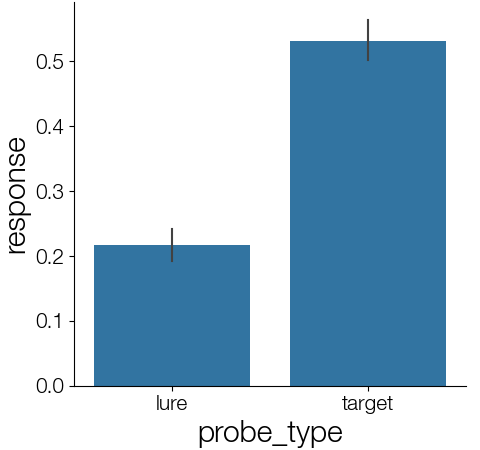

In [4]:
g = sns.catplot(data=perf, x="probe_type", y="response", kind="bar")

To make this plot, we indicated that the x-axis should be based on the `probe_type` column and the y-axis should be based on the `response` column. The `barplot` function automatically split our data into "lure" and "target" bins and calculated the mean response. It also calculated 95% confidence intervals using a bootstrap method.

We can make exactly the same plot using a horizontal bar plot, if we exchange the x-axis and y-axis inputs. This is sometimes useful if the labels of the different categories are long, as long labels are harder to fit on the x-axis.

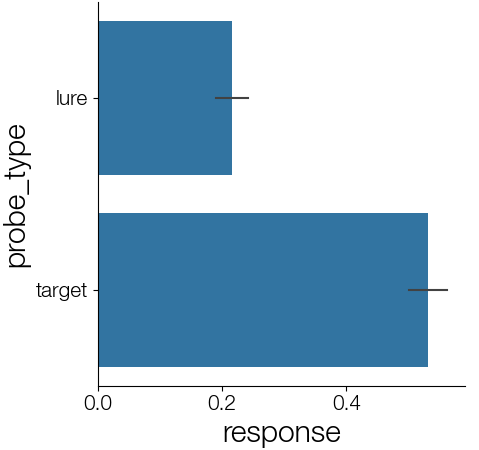

In [5]:
g = sns.catplot(data=perf, x="response", y="probe_type", kind="bar")

Bar plots just show the means and uncertainty in the means. We can also make *swarm plots* that show the individual points in the different distributions. This is more complicated to look at, but it gives a more realistic sense of the data.

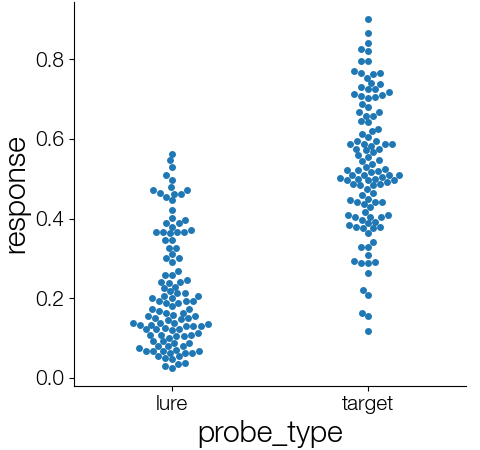

In [6]:
g = sns.catplot(data=perf, x="probe_type", y="response", kind="swarm")

Another common type of plot is called a *box plot*. It shows more detail than a bar plot, but does not show individual points like a swarm plot. The box shows the middle *quartiles* of the distribution. The quartiles include the 25th, 50th, and 75th percentiles. Box plots separate out points that are near the central tendency of the distribution from *outliers*. 

Outliers are determined based on the interquartile range (IQR), which is the difference between the 75th and 25th percentiles.

Points are considered outliers if they are more than 1.5 IQRs away from the nearest quartile. The whiskers at the top and bottom show the range of points that are *not* outliers. Any outliers are plotted as individual points.

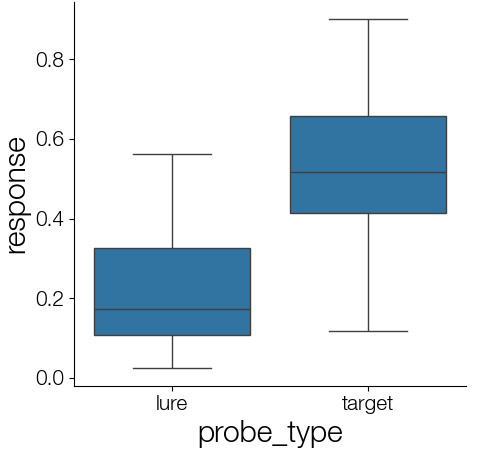

In [7]:
g = sns.catplot(data=perf, x="probe_type", y="response", kind="box")

Swarm plots give a better sense of the underlying data, but box plots make the range and median of the data easy to see.

Sometimes we care about multiple dimensions of the data. For example, we can split the responses up by whether they were faster than the median or slower than the median.

In [8]:
rtm = data.with_columns(rt_median=pl.col("RT").median().over("subj", "probe_type", "response"))
speed = rtm.with_columns(
    speed=pl.when(pl.col("RT") > pl.col("rt_median")).then(pl.lit("slow")).otherwise(pl.lit("fast"))
)
speed.head(6)

subj,cycle,phase,trial,type,word1,word2,response,RT,correct,lag,probe_type,rt_median,speed
i64,i64,str,i64,str,str,str,i64,f64,i64,i64,str,f64,str
101,0,"""test""",-1,"""rearranged""","""waste""","""degree""",0,2.312,1,2,"""lure""",1.584,"""slow"""
101,0,"""test""",0,"""rearranged""","""needed""","""able""",0,3.542,1,1,"""lure""",1.584,"""slow"""
101,0,"""test""",1,"""rearranged""","""single""","""clean""",0,2.084,1,3,"""lure""",1.584,"""slow"""
101,0,"""test""",2,"""rearranged""","""train""","""useful""",0,1.669,1,2,"""lure""",1.584,"""slow"""
101,0,"""test""",3,"""rearranged""","""knees""","""various""",0,2.326,1,5,"""lure""",1.584,"""slow"""
101,0,"""test""",4,"""intact""","""skin""","""careful""",1,1.407,1,null,"""target""",1.287,"""slow"""


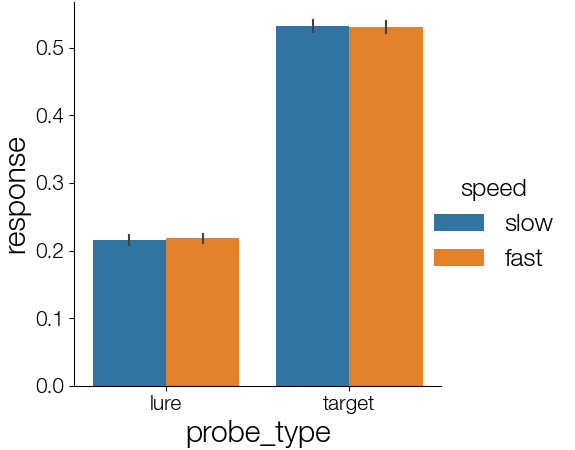

In [9]:
sns.catplot(data=speed, x="probe_type", y="response", hue="speed", kind="bar")

## Relational plots

## Color palettes

## Style options

## Objects interface